In [1]:
import numpy as np
import pandas as pd
import datetime

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from scipy.special import softmax

from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer

import time

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

In [26]:
import warnings

warnings.filterwarnings('ignore')

In [27]:
device = torch.device("cpu")
device

device(type='cpu')

#### Vorbereitungs- / Evaluations-Funktionen

In [2]:
def create_dataset(tokenizer, max_len, labels_data, tweets_data):
    input_ids = []
    attention_masks = []

    for tweet in tweets_data:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels_data)
    dataset = TensorDataset(input_ids, attention_masks, labels)

    return dataset

In [3]:
def get_dataloader(batch_size, dataset, sampler):
    if sampler == "random":
        return DataLoader(
            dataset,
            sampler=RandomSampler(dataset),
            batch_size=batch_size
        )

    if sampler == "sequential":
        return DataLoader(
            dataset,
            sampler=SequentialSampler(dataset),
            batch_size=batch_size
        )

In [4]:
def get_max_len(tweets, tokenizer):
    max_len = 0

    for sent in tweets:
        input_ids = tokenizer.encode(sent, add_special_tokens=True)
        max_len = max(max_len, len(input_ids))
    return max_len

In [5]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [6]:
def evaluate_model(test_dataloader, model, batch_size, data_size):
    predictions = []
    print("Prediction start.")
    total_t0 = time.time()
    total_batches = data_size / batch_size
    batches_completed = 0

    for batch in test_dataloader:
        t0 = time.time()
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

        batches_completed += 1

    print("Total Prediction took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))
    return predictions

In [7]:
def add_to_eval_df(model_name, y_prediction, y_true, sample_size, df):
    test_acc = accuracy_score(y_true=y_true, y_pred=y_prediction)
    test_precision = precision_score(y_true, y_prediction)
    test_recall = recall_score(y_true, y_prediction)
    test_f1 = f1_score(y_true, y_prediction)
    test_mcc = matthews_corrcoef(y_true, y_prediction)

    df.loc[len(df.index)] = [model_name, sample_size, test_acc, test_precision, test_recall, test_f1, test_mcc]

In [8]:
def eval_model(tokenizer, model, model_name, labels, tweets, batch_size, data_size, df):
    max_len = get_max_len(tweets, tokenizer)
    test_dataset = create_dataset(tokenizer=tokenizer, max_len=max_len, labels_data=labels,
                                  tweets_data=tweets)
    test_dataloader = get_dataloader(batch_size=batch_size, sampler="sequential", dataset=test_dataset)
    predictions = evaluate_model(test_dataloader=test_dataloader, model=model, batch_size=batch_size,
                                 data_size=data_size)

    add_to_eval_df(
        model_name=model_name,
        y_prediction=predictions,
        y_true=labels,
        sample_size=data_size,
        df=df
    )

In [9]:
def eval_roberta_base_model(model, model_name, tokenizer, tweets, labels, sample_size, df):
    predictions = []

    for tweet in tweets:
        encoded_input = tokenizer(tweet, return_tensors='pt')
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

        if np.argmax(scores) == 0:
            predictions.append(1)
        else:
            predictions.append(0)

    test_acc = accuracy_score(labels, predictions)
    test_precision = precision_score(labels, predictions)
    test_recall = recall_score(labels, predictions)
    test_f1 = f1_score(labels, predictions)
    test_mcc = matthews_corrcoef(labels, predictions)

    df.loc[len(df.index)] = [model_name, sample_size, test_acc, test_precision, test_recall, test_f1, test_mcc]

## Modelle

### 1. Roberta sentiment

#### 1.1 roberta base sentiment model

In [47]:
path_roberta_sentiment_base = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer_roberta_sentiment_base = AutoTokenizer.from_pretrained(path_roberta_sentiment_base, map_location=torch.device('cpu'))
model_roberta_sentiment_base = AutoModelForSequenceClassification.from_pretrained(path_roberta_sentiment_base, local_files_only=True)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### 1.2 roberta sentiment tuned mixeddata-cleaned

In [48]:
path_roberta_sentiment_mixed_cleaned = 'models/roberta_sentiment_mixed_cleaned'
tokenizer_roberta_sentiment_mixed_cleaned = AutoTokenizer.from_pretrained(path_roberta_sentiment_mixed_cleaned, local_files_only=True)
model_roberta_sentiment_mixed_cleaned = AutoModelForSequenceClassification.from_pretrained(path_roberta_sentiment_mixed_cleaned,
                                                                    local_files_only=True)

#### 1.3 roberta sentiment tuned mixeddata-uncleaned

In [49]:
path_roberta_sentiment_mixed_uncleaned = 'models/roberta_sentiment_mixed_uncleaned'
tokenizer_roberta_sentiment_mixed_uncleaned = AutoTokenizer.from_pretrained(path_roberta_sentiment_mixed_uncleaned, local_files_only=True)
model_roberta_sentiment_mixed_uncleaned = AutoModelForSequenceClassification.from_pretrained(path_roberta_sentiment_mixed_uncleaned,
                                                                    local_files_only=True)

### 2. Roberta hate

#### 2.1 roberta base hate model

In [51]:
path_roberta_hate_base = f"cardiffnlp/twitter-roberta-base-hate-latest"
tokenizer_roberta_hate_base = AutoTokenizer.from_pretrained(path_roberta_hate_base)
model_roberta_hate_base = AutoModelForSequenceClassification.from_pretrained(path_roberta_hate_base,
                                                                    local_files_only=True)

#### 2.2 roberta hate tuned mixeddata-cleaned

In [4]:
path_roberta_hate_mixed_cleaned = 'models/roberta_hate_mixed_cleaned'
tokenizer_roberta_hate_mixed_cleaned = AutoTokenizer.from_pretrained(path_roberta_hate_mixed_cleaned, local_files_only=True)
model_roberta_hate_mixed_cleaned = AutoModelForSequenceClassification.from_pretrained(path_roberta_hate_mixed_cleaned,
                                                                        local_files_only=True)

Exception: data did not match any variant of untagged enum ModelWrapper at line 250370 column 3

#### 2.3 roberta sentiment tuned mixeddata-uncleaned

In [53]:
path_roberta_hate_mixed_uncleaned = 'models/roberta_hate_mixed_uncleaned'
tokenizer_roberta_hate_mixed_uncleaned = AutoTokenizer.from_pretrained(path_roberta_hate_mixed_uncleaned, local_files_only=True)
model_roberta_hate_mixed_uncleaned = AutoModelForSequenceClassification.from_pretrained(path_roberta_hate_mixed_uncleaned,
                                                                        local_files_only=True)

#### 2.4 roberta sentiment tuned mixeddata-uncleaned (lora)

In [54]:
path_roberta_hate_mixed_uncleaned_lora = 'models/roberta_hate_mixed_uncleaned_lora'
tokenizer_roberta_hate_mixed_uncleaned_lora = AutoTokenizer.from_pretrained(path_roberta_hate_mixed_uncleaned_lora, local_files_only=True)
model_roberta_hate_mixed_uncleaned_lora = AutoModelForSequenceClassification.from_pretrained(path_roberta_hate_mixed_uncleaned_lora,
                                                                        local_files_only=True)

### 3. BERT tuned (base) uncased

In [11]:
PATH_BERT_TUNED = "models/bert/bert_mixed_imran"
tokenizer_bert = BertTokenizer.from_pretrained(PATH_BERT_TUNED, local_files_only=True)
model_bert = AutoModelForSequenceClassification.from_pretrained(PATH_BERT_TUNED, local_files_only=True)

### Daten

In [14]:
batch_size = 16
class_names = ["No Hate-Speech", "Hate Speech"]

#### Testdaten: mixed-data

In [55]:
# df_test = pd.read_csv("../data/test_cleaned.csv", index_col=0)
df_test = pd.read_csv("../../../data/mixed_dataset/test_cleaned.csv", index_col=0)
df_test = df_test[df_test.tweet.notna() & df_test.tweet_cleaned.notna()]

In [56]:
data_size = 32000
data = df_test.sample(n=data_size)

In [57]:
tweets = data["tweet"].values
labels = data["label"].values

#### Testdaten: manual labeled

In [23]:
# df_manual = pd.read_csv("../data/manual_labeled_group.csv", index_col=0)
df_manual = pd.read_csv("../../../data/manual_labeled/manual_labeled_group.csv", index_col=0)
data_size_manual = 400

In [24]:
tweets_manual = df_manual.tweet.values
labels_manual = df_manual.label_manual.values

### 4. Modellvergleich

#### 4.1 Vorhersage von Tweets (mixed data)


In [111]:
evaluation_mixed = pd.DataFrame(
    columns=["model", "sample_size", "test_acc", "test_prec", "test_rec", "test_f1", "test_mcc"])

##### 4.1.1 roberta_sentiment_base

In [112]:
eval_roberta_base_model(model=model_roberta_sentiment_base,
                        tokenizer=tokenizer_roberta_sentiment_base,
                        model_name="roberta_sentiment_base",
                        tweets=tweets,
                        labels=labels,
                        sample_size=data_size,
                        df=evaluation_mixed)

##### 4.1.2 roberta_sentiment_mixed_cleaned

In [113]:
eval_model(tokenizer=tokenizer_roberta_sentiment_mixed_cleaned,
           model=model_roberta_sentiment_mixed_cleaned,
           model_name="roberta_sentiment_mixed_cleaned",
           labels=labels,
           tweets=tweets,
           batch_size=batch_size,
           data_size=data_size,
           df=evaluation_mixed)

Prediction start.
Total Prediction took 0:36:48 (h:mm:ss)


##### 4.1.3 roberta_sentiment_mixed_uncleaned

In [114]:
eval_model(tokenizer=tokenizer_roberta_sentiment_mixed_uncleaned,
           model=model_roberta_sentiment_mixed_uncleaned,
           model_name="roberta_sentiment_mixed_uncleaned",
           labels=labels,
           tweets=tweets,
           batch_size=batch_size,
           data_size=data_size,
           df=evaluation_mixed)

Prediction start.
Total Prediction took 0:36:39 (h:mm:ss)


##### 4.1.4 roberta_sentiment_mixed_uncleaned_lora

##### 4.1.5 roberta_hate_base

In [115]:
eval_model(tokenizer=tokenizer_roberta_hate_base,
           model=model_roberta_hate_base,
           model_name="roberta_hate_base",
           labels=labels,
           tweets=tweets,
           batch_size=batch_size,
           data_size=data_size,
           df=evaluation_mixed)

Prediction start.
Total Prediction took 0:36:43 (h:mm:ss)


##### 4.1.6 roberta_hate_mixed_cleaned

In [116]:
eval_model(tokenizer=tokenizer_roberta_hate_mixed_cleaned,
           model=model_roberta_hate_mixed_cleaned,
           model_name="roberta_hate_mixed_cleaned",
           labels=labels,
           tweets=tweets,
           batch_size=batch_size,
           data_size=data_size,
           df=evaluation_mixed)

Prediction start.
Total Prediction took 0:36:29 (h:mm:ss)


##### 4.1.7 roberta_hate_mixed_cleaned

In [117]:
eval_model(tokenizer=tokenizer_roberta_hate_mixed_uncleaned,
           model=model_roberta_hate_mixed_uncleaned,
           model_name="roberta_hate_mixed_uncleaned",
           labels=labels,
           tweets=tweets,
           batch_size=batch_size,
           data_size=data_size,
           df=evaluation_mixed)

Prediction start.
Total Prediction took 0:36:32 (h:mm:ss)


##### 4.1.8 roberta_hate_mixed_cleaned_lora

In [118]:
eval_model(tokenizer=tokenizer_roberta_hate_mixed_uncleaned_lora,
           model=model_roberta_hate_mixed_uncleaned_lora,
           model_name="roberta_hate_mixed_uncleaned_lora",
           labels=labels,
           tweets=tweets,
           batch_size=batch_size,
           data_size=data_size,
           df=evaluation_mixed)

Prediction start.
Total Prediction took 0:39:21 (h:mm:ss)


##### 4.1.8 bert tuned uncased

In [58]:
eval_model(tokenizer=tokenizer_bert,
           model=model_bert,
           model_name="bert_tuned_uncased_mixed",
           labels=labels,
           tweets=tweets,
           batch_size=batch_size,
           data_size=data_size,
           df=evaluation_mixed)


KeyboardInterrupt



##### Vergleich

In [52]:
evaluation_mixed.to_csv("evaluation/roberta_mixed-testdata_evaluation.csv")

In [59]:
evaluation_mixed = pd.read_csv("evaluation/roberta_mixed-testdata_evaluation.csv", index_col=0)

In [60]:
evaluation_mixed.sort_values(by=["test_f1"], ascending=False)

,model,sample_size,test_acc,test_prec,test_rec,test_f1,test_mcc
5,roberta_hate_mixed_uncleaned,32000,0.840250,0.623585,0.605975,0.614654,0.514003
4,roberta_hate_mixed_cleaned,32000,0.789937,0.500338,0.660523,0.569379,0.441262
7,bert_tuned_uncased_mixed,32000,0.780438,0.484211,0.648272,0.554357,0.420455
2,roberta_sentiment_mixed_uncleaned,32000,0.786375,0.493413,0.601219,0.542007,0.407822
1,roberta_sentiment_mixed_cleaned,32000,0.778625,0.479196,0.609394,0.536509,0.398723
6,roberta_hate_mixed_uncleaned_lora,32000,0.680063,0.369517,0.738704,0.492616,0.332814
3,roberta_hate_base,32000,0.689969,0.375322,0.714328,0.492090,0.330869
0,roberta_sentiment_base,32000,0.504625,0.280842,0.868906,0.424484,0.236342


<Axes: xlabel='model', ylabel='test_f1'>

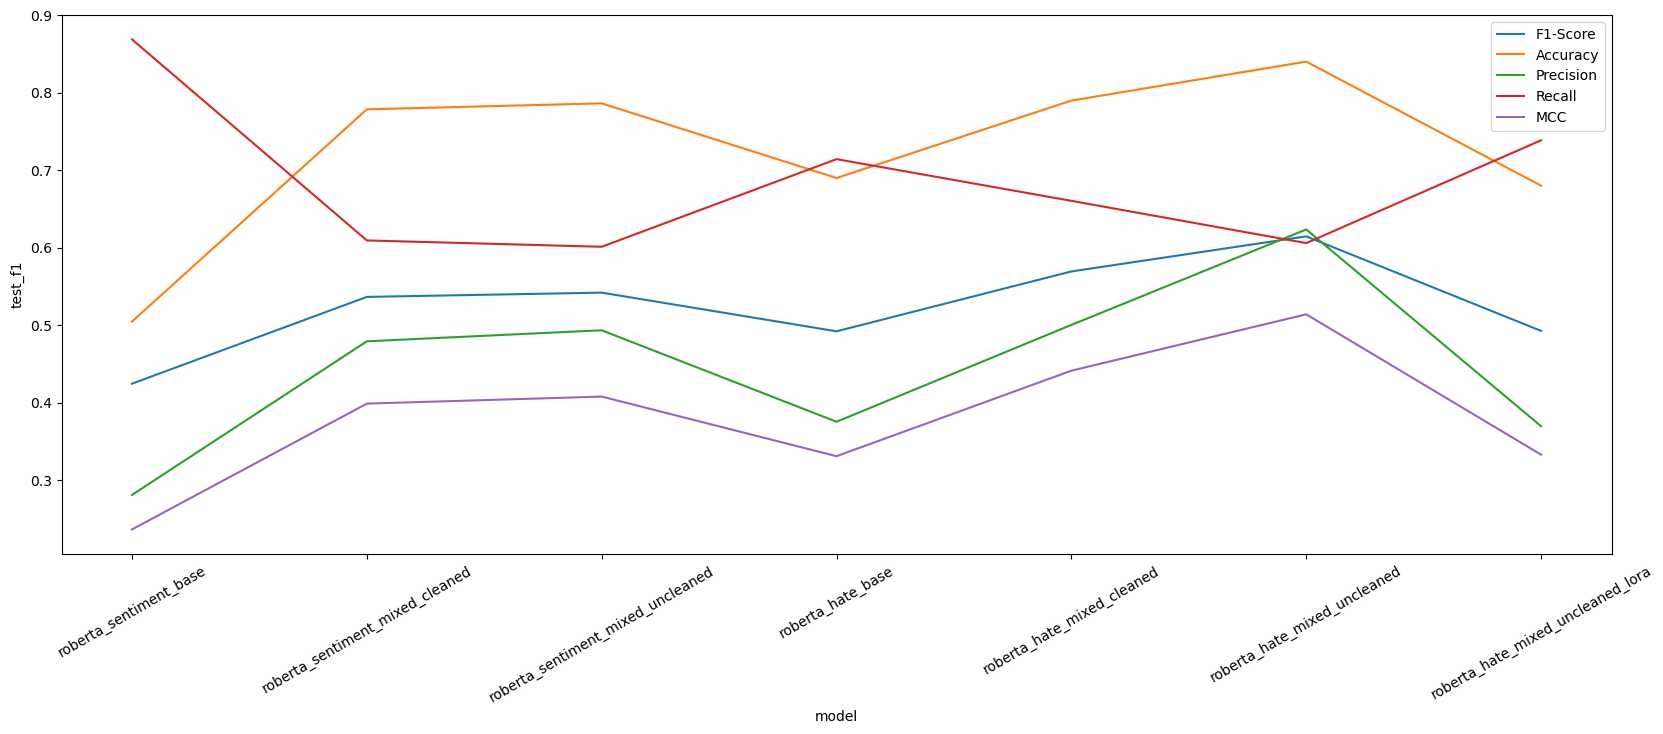

In [121]:
fix, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)
sns.lineplot(data=evaluation_mixed, y=evaluation_mixed.test_f1, x=evaluation_mixed.model, label="F1-Score")
sns.lineplot(data=evaluation_mixed, y=evaluation_mixed.test_acc, x=evaluation_mixed.model, label="Accuracy")
sns.lineplot(data=evaluation_mixed, y=evaluation_mixed.test_prec, x=evaluation_mixed.model, label="Precision")
sns.lineplot(data=evaluation_mixed, y=evaluation_mixed.test_rec, x=evaluation_mixed.model, label="Recall")
sns.lineplot(data=evaluation_mixed, y=evaluation_mixed.test_mcc, x=evaluation_mixed.model, label="MCC")

##### Ergebnis
- Wichtig: Hate-Modell wurde auf Teilmenge der neuen Daten (damit auch Test) bereits traininert, somit bessere Performance logisch
- Basismodelle (beide) deutlich schlechter als nachtrainierte Modelle, das Sentiment-Modell auch deutlich schlechter als das Hate-Modell
- auch bei nachtrainierten Modellen ist das Hate-Modell deutlich besser als das nachtrainierte Sentiment-Modell
- LoRA Training hat nichts bewirkt
- Unbereinigte Daten beim Hate-Modell sehr viel besser als bereinigte Daten (könnte auf Data Leakage hindeuten)
- BERT auf vergleichbarem Niveau wie die Sentiment-Modelle


#### 4.2 Vorhersage von Tweets (manual label)

In [89]:
evaluation_manual = pd.DataFrame(
    columns=["model", "sample_size", "test_acc", "test_prec", "test_rec", "test_f1", "test_mcc"])

##### 4.2.1 roberta_sentiment_base

In [90]:
eval_roberta_base_model(model=model_roberta_sentiment_base,
                        tokenizer=tokenizer_roberta_sentiment_base,
                        model_name="roberta_sentiment_base",
                        tweets=tweets_manual,
                        labels=labels_manual,
                        sample_size=data_size_manual,
                        df=evaluation_manual)

##### 4.2.2 roberta_sentiment_mixed_cleaned

In [91]:
eval_model(tokenizer=tokenizer_roberta_sentiment_mixed_cleaned,
           model=model_roberta_sentiment_mixed_cleaned,
           model_name="roberta_sentiment_mixed_cleaned",
           labels=labels_manual,
           tweets=tweets_manual,
           batch_size=batch_size,
           data_size=data_size_manual,
           df=evaluation_manual)

Prediction start.
Total Prediction took 0:00:32 (h:mm:ss)


##### 4.2.3 roberta_sentiment_mixed_uncleaned

In [92]:
eval_model(tokenizer=tokenizer_roberta_sentiment_mixed_uncleaned,
           model=model_roberta_sentiment_mixed_uncleaned,
           model_name="roberta_sentiment_mixed_uncleaned",
           labels=labels_manual,
           tweets=tweets_manual,
           batch_size=batch_size,
           data_size=data_size_manual,
           df=evaluation_manual)

Prediction start.
Total Prediction took 0:00:30 (h:mm:ss)


##### 4.2.4 roberta_sentiment_mixed_uncleaned_lora

##### 4.2.5 roberta_hate_base

In [94]:
eval_model(tokenizer=tokenizer_roberta_hate_base,
           model=model_roberta_hate_base,
           model_name="roberta_hate_base",
           labels=labels_manual,
           tweets=tweets_manual,
           batch_size=batch_size,
           data_size=data_size_manual,
           df=evaluation_manual)

Prediction start.
Total Prediction took 0:00:35 (h:mm:ss)


##### 4.2.6 roberta_hate_mixed_cleaned

In [96]:
eval_model(tokenizer=tokenizer_roberta_hate_mixed_cleaned,
           model=model_roberta_hate_mixed_cleaned,
           model_name="roberta_hate_mixed_cleaned",
           labels=labels_manual,
           tweets=tweets_manual,
           batch_size=batch_size,
           data_size=data_size_manual,
           df=evaluation_manual)

Prediction start.
Total Prediction took 0:00:36 (h:mm:ss)


##### 4.2.7 roberta_hate_mixed_uncleaned

In [97]:
eval_model(tokenizer=tokenizer_roberta_hate_mixed_uncleaned,
           model=model_roberta_hate_mixed_uncleaned,
           model_name="roberta_hate_mixed_uncleaned",
           labels=labels_manual,
           tweets=tweets_manual,
           batch_size=batch_size,
           data_size=data_size_manual,
           df=evaluation_manual)

Prediction start.
Total Prediction took 0:00:27 (h:mm:ss)


##### 4.2.8 roberta_hate_mixed_uncleaned_lora

In [98]:
eval_model(tokenizer=tokenizer_roberta_hate_mixed_uncleaned_lora,
           model=model_roberta_hate_mixed_uncleaned_lora,
           model_name="roberta_hate_mixed_uncleaned_lora",
           labels=labels_manual,
           tweets=tweets_manual,
           batch_size=batch_size,
           data_size=data_size_manual,
           df=evaluation_manual)

Prediction start.
Total Prediction took 0:00:37 (h:mm:ss)


##### 4.2.9 bert tuned uncased

In [28]:
eval_model(tokenizer=tokenizer_bert,
           model=model_bert,
           model_name="bert_tuned_uncased_mixed",
           labels=labels_manual,
           tweets=tweets_manual,
           batch_size=batch_size,
           data_size=data_size_manual,
           df=evaluation_manual)

Prediction start.
Total Prediction took 0:00:54 (h:mm:ss)


##### Vergleich

In [30]:
evaluation_manual.to_csv("evaluation/roberta_manual-label_evaluation.csv")

In [31]:
evaluation_manual = pd.read_csv("evaluation/roberta_manual-label_evaluation.csv", index_col=0)

In [32]:
evaluation_manual.sort_values(by=["test_f1"], ascending=False)

,model,sample_size,test_acc,test_prec,test_rec,test_f1,test_mcc
4,roberta_hate_mixed_cleaned,400,0.8850,0.914439,0.850746,0.881443,0.771967
6,roberta_hate_mixed_uncleaned_lora,400,0.8725,0.850467,0.905473,0.877108,0.746490
3,roberta_hate_base,400,0.8700,0.856459,0.890547,0.873171,0.740534
1,roberta_sentiment_mixed_cleaned,400,0.8425,0.867021,0.810945,0.838046,0.686545
2,roberta_sentiment_mixed_uncleaned,400,0.8375,0.865591,0.800995,0.832041,0.677019
7,bert_tuned_uncased_mixed,400,0.8200,0.824121,0.815920,0.820000,0.640041
5,roberta_hate_mixed_uncleaned,400,0.8250,0.906832,0.726368,0.806630,0.663724
0,roberta_sentiment_base,400,0.7300,0.658703,0.960199,0.781377,0.516972


<Axes: xlabel='model', ylabel='test_f1'>

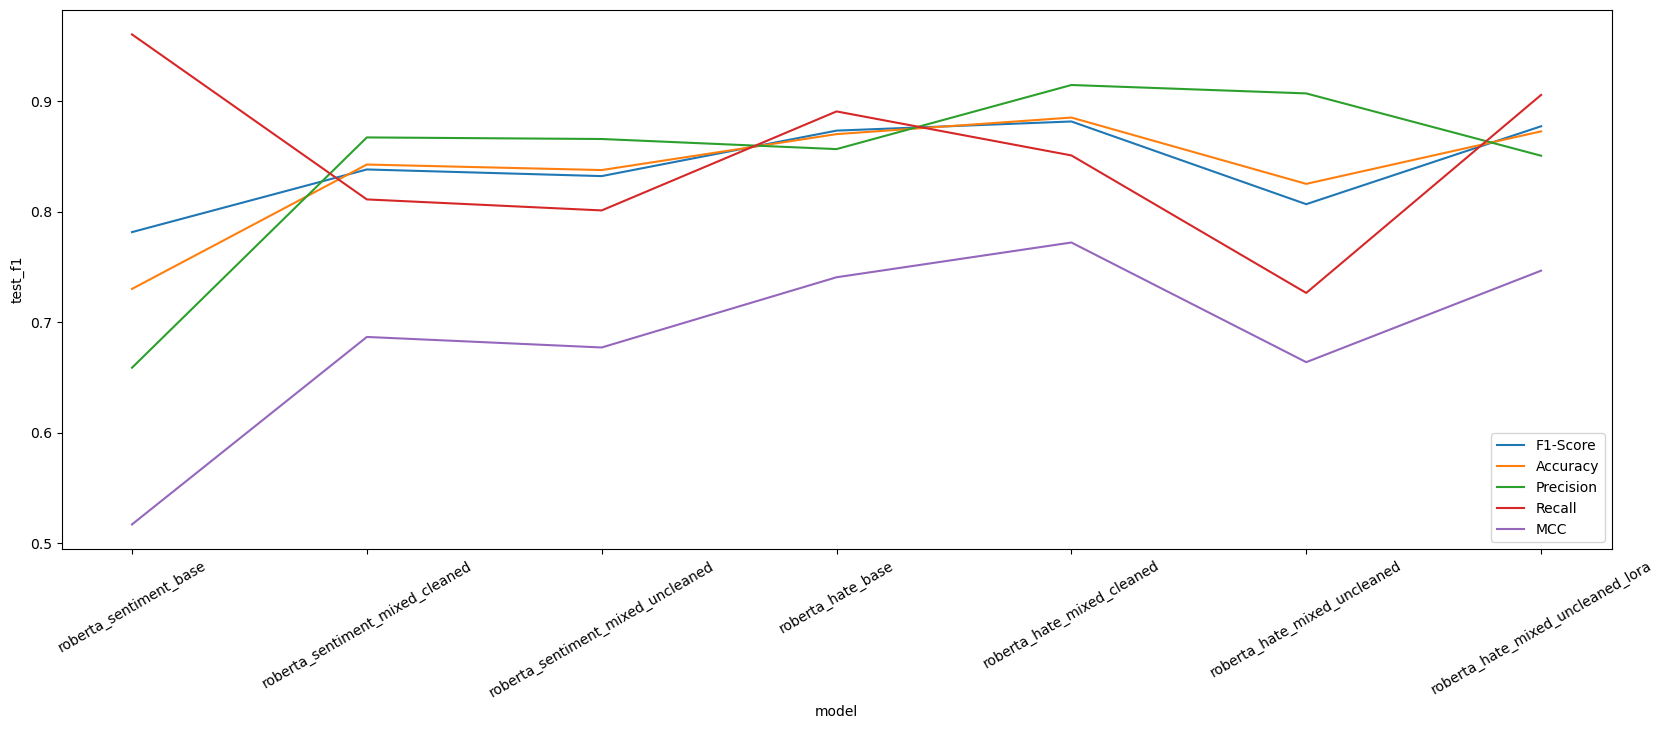

In [101]:
fix, ax = plt.subplots(figsize=(20, 7))
plt.xticks(rotation=30)
sns.lineplot(data=evaluation_manual, y=evaluation_manual.test_f1, x=evaluation_manual.model, label="F1-Score")
sns.lineplot(data=evaluation_manual, y=evaluation_manual.test_acc, x=evaluation_manual.model, label="Accuracy")
sns.lineplot(data=evaluation_manual, y=evaluation_manual.test_prec, x=evaluation_manual.model, label="Precision")
sns.lineplot(data=evaluation_manual, y=evaluation_manual.test_rec, x=evaluation_manual.model, label="Recall")
sns.lineplot(data=evaluation_manual, y=evaluation_manual.test_mcc, x=evaluation_manual.model, label="MCC")

##### Ergebnis
- Data Leakage bei Hate-Modell auch hier wieder möglich, da Daten z.T. aber neu gelabelt wurden nicht so erheblich wie bei den regulären Training-/Testdaten
- anders als bei den Mixed-Daten erzielt das Hate-Basismodell auf den manuell gelabelten Daten schon sehr gute Ergebnisse; Sentiment-Basismodell auch deutlich besser als auf den Mixed-Daten allerdings sichtbar schlechter als das Hate-Basismodell
- Nachtraining kann das Sentiment-Basismodell verbessern, beim Hate-Basismodell führ das Training nur zu einer minimalen Verbesserung des F1-Scores, dabei aber deutliche Verbesserung der Precision
- Cleaned hier deutlich besser als Uncleaned (Hate-Modell)
- LoRA kann im Vergleich zum Hate-Basismodell nur sehr minimale Verbesserung erzeugen
- BERT hier sogar geringfügig schlechter als Sentiment-Modelle